*Performed on Google Colab*

**Importing the libraries**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix

%matplotlib inline

**Version of the tensorflow**

In [2]:
tf.__version__

'1.9.0-rc2'

**Importing the dataset**

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST',one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
print('Size of the training set: '+str(len(data.train.labels)))
print('Size of the test set: '+str(len(data.test.labels)))
print('Size of the validation set: '+str(len(data.validation.labels)))

Size of the training set: 55000
Size of the test set: 10000
Size of the validation set: 5000


In [0]:
data.test.cls = np.argmax(data.test.labels,axis=1)

**Data Dimensions**

In [0]:
img_size = 28
img_shape = (img_size, img_size)
img_flat_size = img_size * img_size

n_classes = 10
n_channels = 1

**Helper Function for plotting images**

In [0]:
def plot_images(images,y_true,y_pred=None):
  assert len(images) == len(y_true) == 9
  
  fig, axes = plt.subplots(3,3)
  fig.subplots_adjust(hspace=0.3,wspace=0.3)
  
  for indx, ax in enumerate(axes.flat):
    ax.imshow(images[indx].reshape(img_shape),cmap='binary')
    
    if y_pred is None:
      xlabel = 'True ' + str(y_true[indx])
    else:
      xlabel = 'True ' + str(y_true[indx]) + ', Pred ' + str(y_pred[indx])
    
    ax.set_xlabel(xlabel)
    
    ax.set_xticks([])
    ax.set_yticks([])
 
  plt.show()

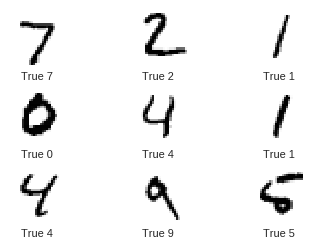

In [9]:
images = data.test.images[:9]
y_true = data.test.cls[:9]

plot_images(images,y_true)

**Tensorflow Graph**

In [0]:
X = tf.placeholder(tf.float32,shape=[None,img_flat_size],name='X')
y = tf.placeholder(tf.float32,shape=[None,n_classes],name='y')

X_images = tf.reshape(X,[-1,img_size,img_size,n_channels])
y_cls  = tf.argmax(y,axis=1)

**Layers Implementation**

In [0]:
net = X_images
net = tf.layers.conv2d(inputs=X_images,name='Layerconv1',padding='SAME',filters=16,activation=tf.nn.relu,kernel_size=5)
conv_layer1 = net
net = tf.layers.max_pooling2d(inputs=net,pool_size=2,strides=2)
net = tf.layers.conv2d(inputs=net,name='Layerconv2',padding='SAME',filters=16,activation=tf.nn.relu,kernel_size=5)
conv_layer2 = net
net = tf.layers.max_pooling2d(inputs=net,pool_size=2,strides=2)
net = tf.contrib.layers.flatten(net)
net = tf.layers.dense(inputs=net,name='FC1',units=128,activation=tf.nn.relu)
net = tf.layers.dense(inputs=net,name='FC2',units=n_classes,activation=None)
logits = net

In [0]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred,axis=1)

**Loss to be optimized**

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y))

**Optimization Method**

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

In [0]:
correct_prediction = tf.equal(y_pred_cls,y_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

**Getting the weights**

In [16]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
  print(var)

<tf.Variable 'Layerconv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'Layerconv1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'Layerconv2/kernel:0' shape=(5, 5, 16, 16) dtype=float32_ref>
<tf.Variable 'Layerconv2/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'FC1/kernel:0' shape=(784, 128) dtype=float32_ref>
<tf.Variable 'FC1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'FC2/kernel:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'FC2/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'Layerconv1/kernel/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'Layerconv1/kernel/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'Layerconv1/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'Layerconv1/bias/Adam_1:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'Layerconv2/kernel/Adam:0' shape=(5, 5, 16, 16) dtype=

In [0]:
def get_weights_variable(layer_name):
  with tf.variable_scope(layer_name,reuse=True):
    variable = tf.get_variable('kernel')
  
  return variable

In [0]:
weights_conv1 = get_weights_variable('Layerconv1')
weights_conv2 = get_weights_variable('Layerconv2')

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
batch_size = 256

In [0]:
total_iterations = 0
import time

def optimize(n_iterations):
  global total_iterations
  
  start = time.time()
  for i in range(n_iterations):
    x_batch, y_batch = data.train.next_batch(batch_size)
    feed_dict = {X:x_batch,y:y_batch}
    
    sess.run(optimizer,feed_dict=feed_dict)
    
    if i%1000 == 0:
      acc = sess.run(accuracy,feed_dict=feed_dict)
      print('Iteration: '+ str(i) + ' Training Accuracy: '+  str(acc))
  total_iterations += n_iterations
  end = time.time()
  
  print('Time Usage: '+ str(end-start))

In [0]:
def plot_example_errors(y_pred,correct):
  incorrect = (correct == False)
  
  images = data.test.images[incorrect]
  y_pred = y_pred[incorrect]
  y_true = data.test.cls[incorrect]
  
  plot_images(images[:9],y_true[:9],y_pred[:9])

In [0]:
def print_confusion_matrix(y_pred):
  y_true = data.test.cls
  
  cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
  
  print(cm)
  
  #Plot Confusion Matrix as an image
  plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Spectral)
  
  plt.tight_layout()
  plt.colorbar()
  tick_marks = np.arange(n_classes)
  plt.xticks(tick_marks,range(n_classes))
  plt.yticks(tick_marks,range(n_classes))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  
  plt.show()

In [0]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,show_confusion_matrix=False):
  n_test = len(data.test.labels)
  
  cls_pred = np.zeros(shape=n_test,dtype=np.int)
  
  i=0
  while i < n_test:
    j = min(i+test_batch_size,n_test)
    
    images = data.test.images[i:j]
    labels = data.test.labels[i:j]
    
    feed_dict = {X:images,y:labels}
    cls_pred[i:j] = sess.run(y_pred_cls,feed_dict=feed_dict)
    
    i = j
  cls_true = data.test.cls
  correct = cls_true == cls_pred
  correct_sum = correct.sum()
  acc = float(correct_sum) / n_test
  print('Accuracy: '+str(acc))
  
  if show_example_errors:
    print('Example errors: ')
    plot_example_errors(cls_pred,correct)
    
  if show_confusion_matrix:
    print('Confusion Matrix: ')
    print_confusion_matrix(cls_pred)

In [42]:
print_test_accuracy()

Accuracy: 0.1596


In [43]:
optimize(1)

Iteration: 0 Training Accuracy: 0.22265625
Time Usage: 0.2613396644592285


In [44]:
print_test_accuracy()

Accuracy: 0.1921


In [45]:
optimize(99)

Iteration: 0 Training Accuracy: 0.23828125
Time Usage: 0.8868155479431152


In [46]:
print_test_accuracy()

Accuracy: 0.9367


In [48]:
optimize(900)

Iteration: 0 Training Accuracy: 0.94921875
Iteration: 100 Training Accuracy: 0.97265625
Iteration: 200 Training Accuracy: 0.97265625
Iteration: 300 Training Accuracy: 0.97265625
Iteration: 400 Training Accuracy: 0.98046875
Iteration: 500 Training Accuracy: 0.98828125
Iteration: 600 Training Accuracy: 0.984375
Iteration: 700 Training Accuracy: 0.9921875
Iteration: 800 Training Accuracy: 0.9921875
Time Usage: 7.82136344909668


Accuracy: 0.9874
Example errors: 


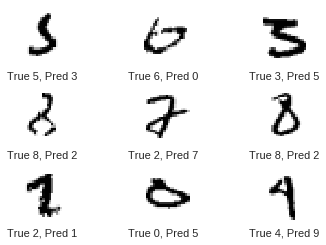

In [52]:
print_test_accuracy(show_example_errors=True)

In [54]:
optimize(9000)

Iteration: 0 Training Accuracy: 0.98828125
Iteration: 1000 Training Accuracy: 0.9921875
Iteration: 2000 Training Accuracy: 0.99609375
Iteration: 3000 Training Accuracy: 1.0
Iteration: 4000 Training Accuracy: 1.0
Iteration: 5000 Training Accuracy: 1.0
Iteration: 6000 Training Accuracy: 1.0
Iteration: 7000 Training Accuracy: 1.0
Iteration: 8000 Training Accuracy: 1.0
Time Usage: 75.50678610801697


Accuracy: 0.9918
Example errors: 


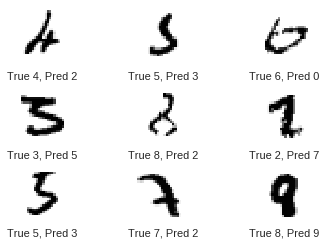

Confusion Matrix: 
[[ 976    0    1    1    0    1    0    0    1    0]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   1    0 1023    2    2    0    0    3    1    0]
 [   0    0    0 1006    0    3    0    0    1    0]
 [   0    0    2    0  974    0    1    0    1    4]
 [   2    0    0    7    0  881    1    0    0    1]
 [   3    2    0    0    3    3  945    0    2    0]
 [   0    1    5    0    0    0    0 1021    0    1]
 [   3    0    2    2    0    2    0    0  962    3]
 [   0    0    0    1    5    2    0    3    0  998]]


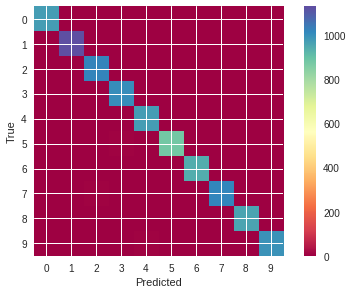

In [55]:
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)